# Import and misc

In [1]:
# Instal latest torch and torchaudio

In [2]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

In [177]:
!wget https://github.com/zakoden/kws_project_2/raw/main/model_teacher
!wget https://github.com/zakoden/kws_project_2/raw/main/model_best
!wget https://github.com/zakoden/kws_project_2/raw/main/model_scripted.pt

--2022-11-06 17:59:16--  https://github.com/zakoden/kws_project_2/raw/main/model_teacher
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/zakoden/kws_project_2/main/model_teacher [following]
--2022-11-06 17:59:16--  https://raw.githubusercontent.com/zakoden/kws_project_2/main/model_teacher
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106037 (104K) [application/octet-stream]
Saving to: ‘model_teacher’

model_teacher       100%[===================>] 103.55K  --.-KB/s    in 0.003s  

2022-11-06 17:59:16 (39.2 MB/s) - ‘model_teacher’ saved [106037/106037]

--2022-11-06 17:59:16--  https://github.c

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [3]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 30
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

In [4]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)

set_random_seed(12345)

# Data

In [5]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2022-11-06 12:53:40--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 172.253.62.128, 2607:f8b0:4004:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|172.253.62.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G   121MB/s    in 9.9s    

2022-11-06 12:53:50 (143 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [6]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [7]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [8]:
dataset.csv.sample(5)

,path,keyword,label
28989,speech_commands/dog/f4f59743_nohash_0.wav,dog,0
3113,speech_commands/marvin/87c62767_nohash_0.wav,marvin,0
5098,speech_commands/happy/aa753bb9_nohash_0.wav,happy,0
29274,speech_commands/dog/a4baac4e_nohash_0.wav,dog,0
31077,speech_commands/right/e72aa705_nohash_0.wav,right,0


### Augmentations

In [9]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [10]:
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [11]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [12]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [13]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [14]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [15]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [16]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [17]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [18]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [19]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [20]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)                      # torch.Size([batch_size, 1, n_mels, n_time])
        conv_output = self.conv(input).transpose(-1, -2)    # torch.Size([batch_size, n_feat, conv_out_frequency * cnn_out_channels])
        gru_output, _ = self.gru(conv_output)               # torch.Size([batch_size, n_feat, hidden_size])
        contex_vector = self.attention(gru_output)          # torch.Size([batch_size, hidden_size])
        output = self.classifier(contex_vector)             # torch.Size([batch_size, 2])
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [21]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [22]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [23]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training teacher

In [ ]:
set_random_seed(12345)

config = TaskConfig(hidden_size=32)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [ ]:
sum([p.numel() for p in model.parameters()])

25387

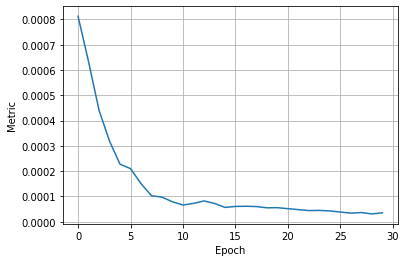

END OF EPOCH 29


In [ ]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.0008124816031697226,
              0.0006331269606191092,
              0.00044093612322150305,
              0.00031877445668836016,
              0.00022742323831654882,
              0.00021011138278371474,
              0.00015072831680397247,
              0.00010274923425175383,
              9.745005199971773e-05,
              7.877162807080673e-05,
              6.623381060287001e-05,
              7.253554084853453e-05,
              8.238796190496651e-05,
              7.245199518239884e-05,
              5.677524768679207e-05,
              6.057657549596661e-05,
              6.136429177667467e-05,
              6.014094452254473e-05,
              5.5152074744726965e-05,
              5.5659316289122304e-05,
              5.1774442813812076e-05,
              4.796714745705641e-05,
              4.427323550434206e-05,
              4.4935633285846576e-05,
              4.2817153894548364e-05,
              3.8329558113544826

In [ ]:
model_teacher = model

In [ ]:
torch.save(model_teacher.state_dict(), "model_teacher")

# Distillation

## compression & speed utils

In [24]:
!pip install thop

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [178]:
set_random_seed(12345)
config = TaskConfig(hidden_size=32)
model_teacher = CRNN(config).to(config.device)
model_teacher.load_state_dict(torch.load("model_teacher"))

print(model_teacher)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [179]:
import tempfile

def get_size_in_megabytes(model):
    # https://pytorch.org/tutorials/recipes/recipes/dynamic_quantization.html#look-at-model-size
    with tempfile.TemporaryFile() as f:
        torch.save(model.state_dict(), f)
        size = f.tell() / 2**20
    return size

model_teacher_size = get_size_in_megabytes(model_teacher)
print(model_teacher_size)

0.10112476348876953


In [180]:
from thop import profile  # !pip install thop

config = TaskConfig()

def get_macs(model):
  input_tensor = torch.randn(1, 2 * config.sample_rate)
  input_tensor = melspec_val(input_tensor)
  return profile(model, (input_tensor, ))[0]

model_teacher_macs = get_macs(model_teacher)
print(model_teacher_macs)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
904608.0


In [181]:
def model_calc_stats(model):
  compression_rate = model_teacher_size / get_size_in_megabytes(model)
  speed_up_rate = model_teacher_macs / get_macs(model)
  return compression_rate, speed_up_rate

In [182]:
model_calc_stats(model_teacher)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


(0.977218479573123, 1.0)

## train utils

In [30]:
def train_epoch_with_teacher(model_teacher, model, opt, loader, log_melspec, device):
    model.train()
    model_teacher.eval()
    all_losses = [[], [], []]
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        logits = model(batch)
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        # teacher
        with torch.no_grad():
          logits_teacher = model_teacher(batch) / 3.0
          probs_teacher = F.softmax(logits_teacher, dim=-1)
        loss_distillation = F.cross_entropy(logits / 3.0, probs_teacher)

        loss_full = loss + loss_distillation

        all_losses[0].append(loss_full.item())
        all_losses[1].append(loss.item())
        all_losses[2].append(loss_distillation.item())

        loss_full.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return all_losses

In [31]:
def train_with_teacher(n_epochs):
  all_losses = None
  for n in range(n_epochs):

    part_all_losses = train_epoch_with_teacher(model_teacher, model, opt, train_loader,
                                               melspec_train, config.device)
    if all_losses is None:
      all_losses = part_all_losses
    else:
      for loss_id in range(len(part_all_losses)):
        all_losses[loss_id].extend(part_all_losses[loss_id])

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.plot([5e-5 * 1.1] * len(history['val_metric']))
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    plt.plot(all_losses[0], label="final loss")
    for loss_id in range(len(all_losses) - 1):
      plt.plot(all_losses[loss_id + 1], label = "loss " + str(loss_id + 1))
    plt.ylabel('Loss')
    plt.xlabel('Iter')
    plt.legend()
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

    if au_fa_fr < 5e-5:
      break

## Experiment 1 (Dark Knowledge Distillation)

In [ ]:
experiment_1_data = {"compression_rate": [],
                     "speed_up_rate": [],
                     "metric": []}

### model_1

In [ ]:
set_random_seed(12345)
history = defaultdict(list)
config = TaskConfig(hidden_size=16, cnn_out_channels=4)
model = CRNN(config).to(config.device)

print(model)

compression_rate, speed_up_rate = model_calc_stats(model)
print("compression_rate, speed_up_rate:", compression_rate, speed_up_rate)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(72, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
compression_rate, speed_up_rate: 3.396335799622049 2.8815938557826066


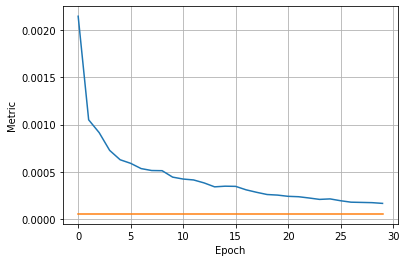

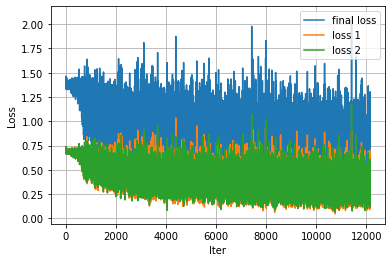

END OF EPOCH 29


In [ ]:
train_with_teacher(30)

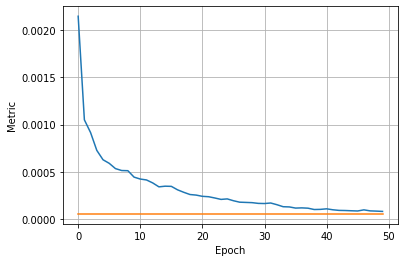

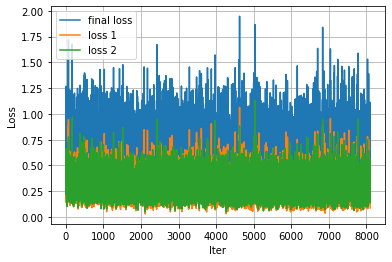

END OF EPOCH 19


In [ ]:
train_with_teacher(20)

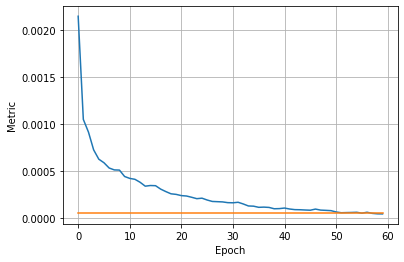

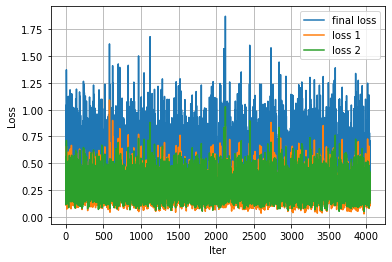

END OF EPOCH 9


In [ ]:
train_with_teacher(10)

In [ ]:
metric = np.min(history['val_metric'])

experiment_1_data["compression_rate"].append(compression_rate)
experiment_1_data["speed_up_rate"].append(speed_up_rate)
experiment_1_data["metric"].append(metric)

In [ ]:
experiment_1_data

{'compression_rate': [3.396335799622049],
 'speed_up_rate': [2.8815938557826066],
 'metric': [4.6696059822277484e-05]}

### model_2

In [ ]:
set_random_seed(12345)
history = defaultdict(list)
config = TaskConfig(hidden_size=16, cnn_out_channels=4, stride=(2, 10))
model = CRNN(config).to(config.device)

print(model)

compression_rate, speed_up_rate = model_calc_stats(model)
print("compression_rate, speed_up_rate:", compression_rate, speed_up_rate)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 4, kernel_size=(5, 20), stride=(2, 10))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(72, 16, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=16, out_features=16, bias=True)
      (1): Tanh()
      (2): Linear(in_features=16, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
compression_rate, speed_up_rate: 3.396335799622049 3.6013162075368603


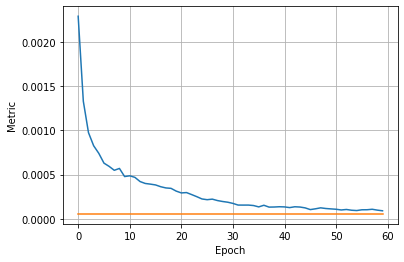

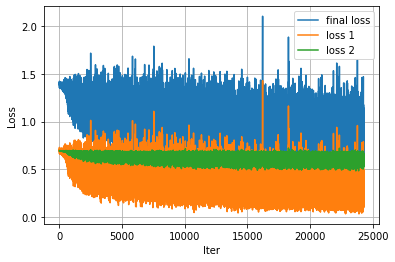

END OF EPOCH 59


In [ ]:
train_with_teacher(60)

In [ ]:
metric = np.min(history['val_metric'])

experiment_1_data["compression_rate"].append(compression_rate)
experiment_1_data["speed_up_rate"].append(speed_up_rate)
experiment_1_data["metric"].append(metric)
experiment_1_data

{'compression_rate': [3.396335799622049, 3.396335799622049],
 'speed_up_rate': [2.8815938557826066, 3.6013162075368603],
 'metric': [4.6696059822277484e-05, 9.04381835918997e-05]}

### model_3

In [ ]:
set_random_seed(12345)
history = defaultdict(list)
config = TaskConfig(hidden_size=12, cnn_out_channels=3, kernel_size=(7, 20), stride=(6, 10), gru_num_layers=2)
model = CRNN(config).to(config.device)

print(model)

compression_rate, speed_up_rate = model_calc_stats(model)
print("compression_rate, speed_up_rate:", compression_rate, speed_up_rate)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 3, kernel_size=(7, 20), stride=(6, 10))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(18, 12, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=12, out_features=12, bias=True)
      (1): Tanh()
      (2): Linear(in_features=12, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=12, out_features=2, bias=True)
)
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
compression_rate, speed_up_rate: 6.8797119314864075 9.965678195241678


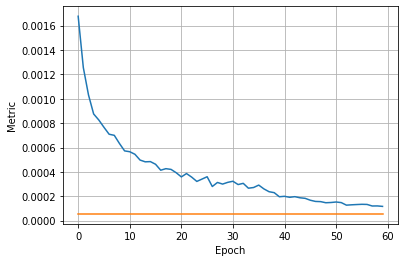

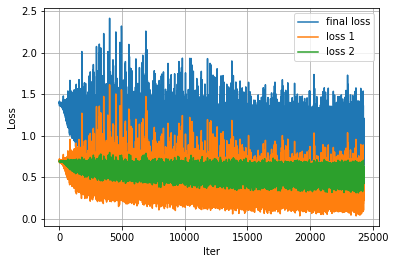

END OF EPOCH 59


In [ ]:
train_with_teacher(60)

In [ ]:
sum([p.numel() for p in model.parameters()])

2706

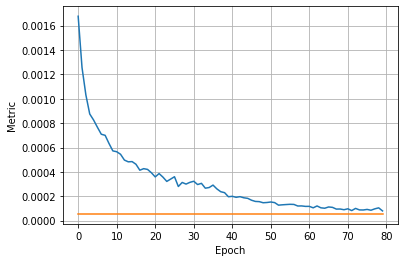

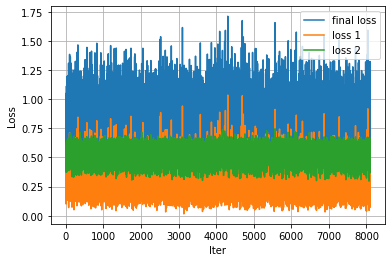

END OF EPOCH 19


In [ ]:
train_with_teacher(20)

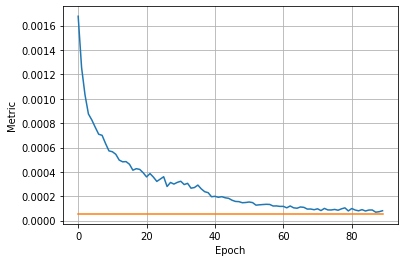

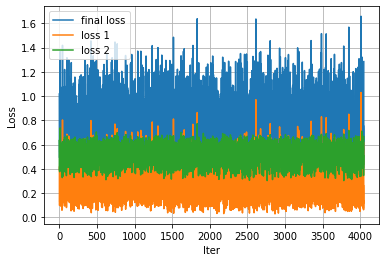

END OF EPOCH 9


In [ ]:
train_with_teacher(10)

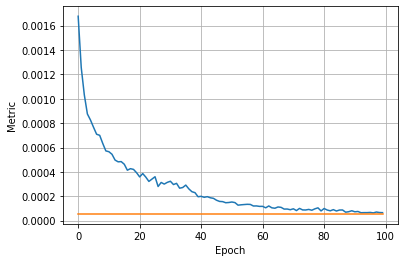

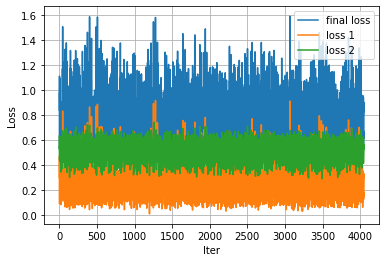

END OF EPOCH 9


In [ ]:
train_with_teacher(10)

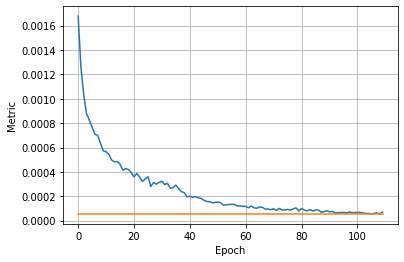

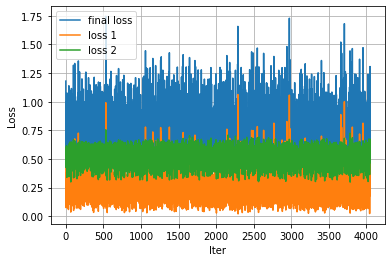

END OF EPOCH 9


In [ ]:
train_with_teacher(10)

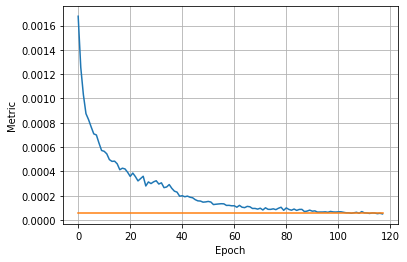

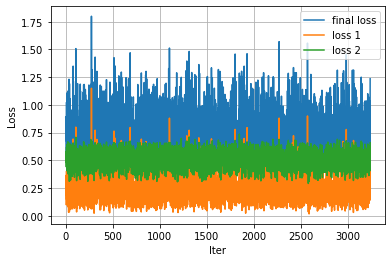

END OF EPOCH 7


In [ ]:
train_with_teacher(10)

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.0016770897344605433,
              0.0012557987778760932,
              0.001031645755633999,
              0.0008750990799384328,
              0.0008256519806812583,
              0.000765737802966796,
              0.0007088193341380571,
              0.000699939623337348,
              0.0006331030904287847,
              0.0005721624945303696,
              0.0005653326363237759,
              0.0005444730737539649,
              0.0004968759142469381,
              0.0004824941245764346,
              0.00048423664847012214,
              0.00046253267791758257,
              0.0004136883009661012,
              0.0004262619237195247,
              0.0004203242138763085,
              0.00039309429426365004,
              0.0003586883986846929,
              0.00038617193906954894,
              0.0003570682095164183,
              0.0003216687172652042,
              0.0003407260804655165,
              0.0003600997236876281,
     

In [ ]:
torch.save(model.state_dict(), "model_best")

## Experiment 2 (Attention Distillation + Dark Knowledge Distillation)

### new train utils

In [136]:
def train_epoch_with_teacher(model_teacher, model, opt, loader, log_melspec, device):
    model.train()
    model_teacher.eval()
    all_losses = [[], [], [], []]
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        input = batch.unsqueeze(dim=1)                       # torch.Size([batch_size, 1, n_mels, n_time])
        conv_output = model.conv(input).transpose(-1, -2)    # torch.Size([batch_size, n_feat, conv_out_frequency * cnn_out_channels])
        gru_output, _ = model.gru(conv_output)               # torch.Size([batch_size, n_feat, hidden_size])
        energy = model.attention.energy(gru_output)          # torch.Size([batch_size, n_feat, 1])
        alpha = torch.softmax(energy, dim=-2)
        contex_vector = (gru_output * alpha).sum(dim=-2)     # torch.Size([batch_size, hidden_size])
        logits = model.classifier(contex_vector)             # torch.Size([batch_size, 2])
        probs = F.softmax(logits, dim=-1)

        loss = F.cross_entropy(logits, labels)

        # teacher
        with torch.no_grad():
          input_teacher = batch.unsqueeze(dim=1)                      
          conv_output_teacher = model_teacher.conv(input_teacher).transpose(-1, -2)   
          gru_output_teacher, _ = model_teacher.gru(conv_output_teacher)              
          energy_teacher = model_teacher.attention.energy(gru_output_teacher)   
          alpha_teacher = torch.softmax(energy_teacher, dim=-2)
          contex_vector_teacher = (gru_output_teacher * alpha_teacher).sum(dim=-2)   
          logits_teacher = model_teacher.classifier(contex_vector_teacher)         
          probs_teacher = F.softmax(logits_teacher / 3.0, dim=-1)
        loss_distillation = F.cross_entropy(logits / 3.0, probs_teacher)
        loss_attention = 0.2 * F.cross_entropy(energy[:, :, 0], alpha_teacher[:, :, 0])

        loss_full = loss + loss_distillation + loss_attention

        all_losses[0].append(loss_full.item())
        all_losses[1].append(loss.item())
        all_losses[2].append(loss_distillation.item())
        all_losses[3].append(loss_attention.item())

        loss_full.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return all_losses

In [137]:
def train_with_teacher(n_epochs):
  all_losses = None
  for n in range(n_epochs):

    part_all_losses = train_epoch_with_teacher(model_teacher, model, opt, train_loader,
                                               melspec_train, config.device)
    if all_losses is None:
      all_losses = part_all_losses
    else:
      for loss_id in range(len(part_all_losses)):
        all_losses[loss_id].extend(part_all_losses[loss_id])

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.plot([5e-5 * 1.1] * len(history['val_metric']))
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    plt.plot(all_losses[0], label="final loss")
    for loss_id in range(len(all_losses) - 1):
      plt.plot(all_losses[loss_id + 1], label = "loss " + str(loss_id + 1))
    plt.ylabel('Loss')
    plt.xlabel('Iter')
    plt.legend()
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

### model_1

In [138]:
set_random_seed(12345)
history = defaultdict(list)
config = TaskConfig(hidden_size=12, cnn_out_channels=3, stride=(2, 8))
model = CRNN(config).to(config.device)

print(model)

compression_rate, speed_up_rate = model_calc_stats(model)
print("compression_rate, speed_up_rate:", compression_rate, speed_up_rate)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 3, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(54, 12, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=12, out_features=12, bias=True)
      (1): Tanh()
      (2): Linear(in_features=12, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=12, out_features=2, bias=True)
)
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
compression_rate, speed_up_rate: 5.2794124968882254 4.31777306833152


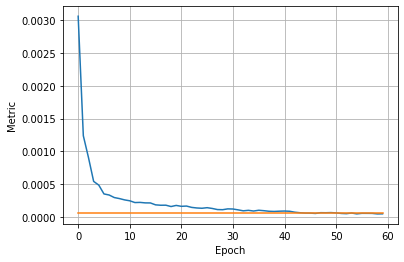

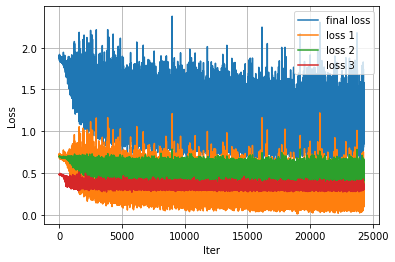

END OF EPOCH 59


In [139]:
train_with_teacher(60)

In [140]:
metric = np.min(history['val_metric'])
print(metric)

4.710782060537488e-05


### model_2

In [146]:
set_random_seed(12345)
history = defaultdict(list)
config = TaskConfig(hidden_size=10, cnn_out_channels=3, stride=(4, 8))
model = CRNN(config).to(config.device)

print(model)

compression_rate, speed_up_rate = model_calc_stats(model)
print("compression_rate, speed_up_rate:", compression_rate, speed_up_rate)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 3, kernel_size=(5, 20), stride=(4, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(27, 10, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=10, out_features=10, bias=True)
      (1): Tanh()
      (2): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=10, out_features=2, bias=True)
)
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
compression_rate, speed_up_rate: 7.821568193553146 8.226700618406694


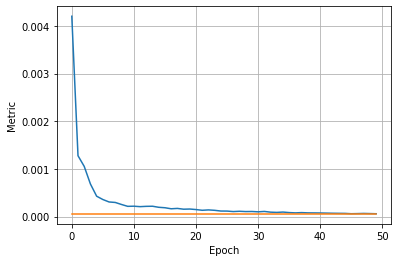

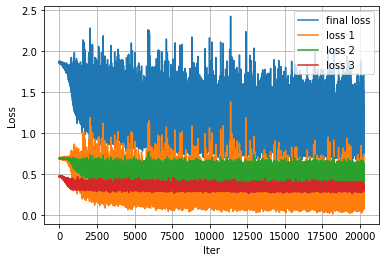

END OF EPOCH 49


In [147]:
train_with_teacher(50)

In [148]:
metric = np.min(history['val_metric'])
print(metric)

5.875647348372449e-05


## Experiment 3 (Quantization)

In [189]:
best_model_dict = torch.load("model_best")
keys_to_delete = ["total_ops", "total_params", "conv.1.total_ops", "conv.1.total_params", "attention.total_ops", "attention.total_params", "attention.energy.1.total_ops", "attention.energy.1.total_params"]

for key in keys_to_delete:
  best_model_dict.pop(key)

In [190]:
set_random_seed(12345)
config = TaskConfig(hidden_size=12, cnn_out_channels=3, kernel_size=(7, 20), stride=(6, 10), gru_num_layers=2)
model = CRNN(config).to(config.device)
model.load_state_dict(best_model_dict)

<All keys matched successfully>

In [191]:
compression_rate = model_teacher_size / get_size_in_megabytes(model)
print("best_model compression_rate:", compression_rate)
metric = validation(model, val_loader, melspec_val, config.device)
print("metric:", metric)

model_dynamic_quantized = torch.quantization.quantize_dynamic(
    model, qconfig_spec={torch.nn.GRU}, dtype=torch.qint8
)
compression_rate = model_teacher_size / get_size_in_megabytes(model_dynamic_quantized)
print("best_model + dq_GRU compression_rate:", compression_rate)
metric = validation(model_dynamic_quantized, val_loader, melspec_val, config.device)
print("metric:", metric)

model_dynamic_quantized = torch.quantization.quantize_dynamic(
    model, qconfig_spec={torch.nn.Linear}, dtype=torch.qint8
)
compression_rate = model_teacher_size / get_size_in_megabytes(model_dynamic_quantized)
print("best_model + dq_Linear compression_rate:", compression_rate)
metric = validation(model_dynamic_quantized, val_loader, melspec_val, config.device)
print("metric:", metric)

model_dynamic_quantized = torch.quantization.quantize_dynamic(
    model, qconfig_spec={torch.nn.GRU, torch.nn.Linear}, dtype=torch.qint8
)
compression_rate = model_teacher_size / get_size_in_megabytes(model_dynamic_quantized)
print("best_model + dq_GRU + dq_Linear compression_rate:", compression_rate)
metric = validation(model_dynamic_quantized, val_loader, melspec_val, config.device)
print("metric:", metric)

best_model compression_rate: 6.8797119314864075


102it [00:10, 10.07it/s]


metric: 4.994240570640769e-05
best_model + dq_GRU compression_rate: 10.113209346685741


102it [00:11,  9.05it/s]


metric: 4.991256796850209e-05
best_model + dq_Linear compression_rate: 6.23930567814063


102it [00:11,  8.84it/s]


metric: 4.968580116041946e-05
best_model + dq_GRU + dq_Linear compression_rate: 8.881564620152442


102it [00:11,  9.22it/s]


metric: 4.947992076887077e-05


In [162]:
print(get_size_in_megabytes(model.conv))
print(get_size_in_megabytes(model.gru))
print(get_size_in_megabytes(model.attention))
print(get_size_in_megabytes(model.classifier))

0.0026617050170898438
0.010207176208496094
0.0021047592163085938
0.0010747909545898438


In [163]:
print(get_size_in_megabytes(model_dynamic_quantized.conv))
print(get_size_in_megabytes(model_dynamic_quantized.gru))
print(get_size_in_megabytes(model_dynamic_quantized.attention))
print(get_size_in_megabytes(model_dynamic_quantized.classifier))

0.0026617050170898438
0.005446434020996094
0.0030660629272460938
0.0017385482788085938


## Plots

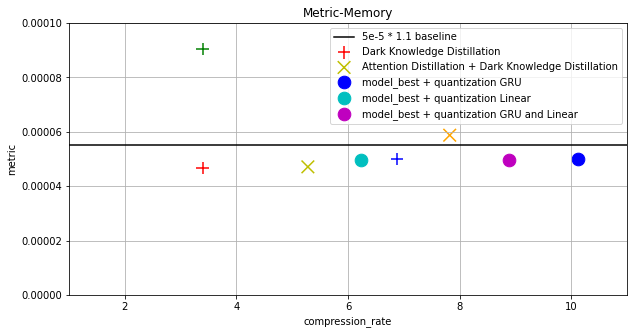

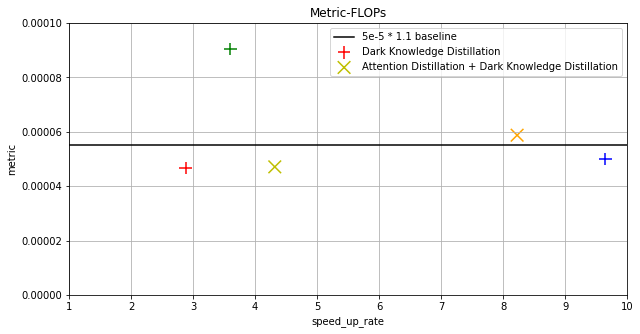

In [192]:
experiment_1_plot = {
    'compression_rate': [3.396335799622049, 3.396335799622049, 6.8797119314864075],
    'speed_up_rate': [2.8815938557826066, 3.6013162075368603, 9.651004992958647],
    'metric': [4.6696059822277484e-05, 9.04381835918997e-05, 4.994240570640769e-05]
    }

experiment_2_plot = {
    'compression_rate': [5.2794124968882254, 7.821568193553146],
    'speed_up_rate': [4.31777306833152, 8.226700618406694],
    'metric': [4.710782060537488e-05, 5.875647348372449e-05]
    }

experiment_3_plot = {
    'compression_rate': [10.113209346685741, 6.23930567814063, 8.881564620152442],
    'metric': [4.991256796850209e-05, 4.968580116041946e-05, 4.947992076887077e-05]
    }

plt.figure(figsize=(10, 5))
plt.title("Metric-Memory")
plt.scatter(experiment_1_plot['compression_rate'], experiment_1_plot['metric'], s=160, c=['r', 'g', 'b'], 
            label="Dark Knowledge Distillation", marker='+')
plt.scatter(experiment_2_plot['compression_rate'], experiment_2_plot['metric'], s=160, c=['y', 'orange'], 
            label="Attention Distillation + Dark Knowledge Distillation", marker='x')

plt.scatter(experiment_3_plot['compression_rate'][0], experiment_3_plot['metric'][0], s=160, c=['b'], 
            label="model_best + quantization GRU", marker='o')
plt.scatter(experiment_3_plot['compression_rate'][1], experiment_3_plot['metric'][1], s=160, c=['c'], 
            label="model_best + quantization Linear", marker='o')
plt.scatter(experiment_3_plot['compression_rate'][2], experiment_3_plot['metric'][2], s=160, c=['m'], 
            label="model_best + quantization GRU and Linear", marker='o')

plt.plot(np.linspace(1.0, 11.0, 100), [5.5e-5] * 100, color='black', label='5e-5 * 1.1 baseline')
plt.xlim(1.0, 11.0)
plt.ylim(0.0, 10.0e-5)
plt.ylabel('metric')
plt.xlabel('compression_rate')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.title("Metric-FLOPs")
plt.scatter(experiment_1_plot['speed_up_rate'], experiment_1_plot['metric'], s=160, c=['r', 'g', 'b'], 
            label="Dark Knowledge Distillation", marker='+')
plt.scatter(experiment_2_plot['speed_up_rate'], experiment_2_plot['metric'], s=160, c=['y', 'orange'], 
            label="Attention Distillation + Dark Knowledge Distillation", marker='x')
plt.plot(np.linspace(1.0, 10.0, 100), [5.5e-5] * 100, color='black', label='5e-5 * 1.1 baseline')
plt.xlim(1.0, 10.0)
plt.ylim(0.0, 10.0e-5)
plt.ylabel('metric')
plt.xlabel('speed_up_rate')
plt.legend()
plt.grid()
plt.show()

## Best model + quantization metrics

In [193]:
best_model_dict = torch.load("model_best")

In [194]:
keys_to_delete = ["total_ops", "total_params", "conv.1.total_ops", "conv.1.total_params", "attention.total_ops", "attention.total_params", "attention.energy.1.total_ops", "attention.energy.1.total_params"]

for key in keys_to_delete:
  best_model_dict.pop(key)

In [195]:
set_random_seed(12345)
config = TaskConfig(hidden_size=12, cnn_out_channels=3, kernel_size=(7, 20), stride=(6, 10), gru_num_layers=2)
model = CRNN(config).to(config.device)
model.load_state_dict(best_model_dict)

print(model)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 3, kernel_size=(7, 20), stride=(6, 10))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(18, 12, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=12, out_features=12, bias=True)
      (1): Tanh()
      (2): Linear(in_features=12, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=12, out_features=2, bias=True)
)


In [196]:
model_dynamic_quantized = torch.quantization.quantize_dynamic(
    model, qconfig_spec={torch.nn.GRU}, dtype=torch.qint8
)

In [197]:
model_dynamic_quantized

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 3, kernel_size=(7, 20), stride=(6, 10))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): DynamicQuantizedGRU(18, 12, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=12, out_features=12, bias=True)
      (1): Tanh()
      (2): Linear(in_features=12, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=12, out_features=2, bias=True)
)

In [198]:
compression_rate = model_teacher_size / get_size_in_megabytes(model_dynamic_quantized)
speed_up_rate = model_teacher_macs / get_macs(model)
metric = validation(model_dynamic_quantized, val_loader, melspec_val, config.device)
print("compression_rate:", compression_rate)
print("speed_up_rate:", speed_up_rate)
print("metric:", metric)

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.


102it [00:10,  9.88it/s]


compression_rate: 10.113209346685741
speed_up_rate: 9.651004992958647
metric: 4.991256796850209e-05


# Streaming

In [32]:
!wget https://github.com/markovka17/dla/raw/2022/hw2_kws/kws.pth

--2022-11-06 12:55:16--  https://github.com/markovka17/dla/raw/2022/hw2_kws/kws.pth
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markovka17/dla/2022/hw2_kws/kws.pth [following]
--2022-11-06 12:55:17--  https://raw.githubusercontent.com/markovka17/dla/2022/hw2_kws/kws.pth
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 343294 (335K) [application/octet-stream]
Saving to: ‘kws.pth’

kws.pth             100%[===================>] 335.25K  --.-KB/s    in 0.004s  

2022-11-06 12:55:17 (86.8 MB/s) - ‘kws.pth’ saved [343294/343294]



In [200]:
!wget https://raw.githubusercontent.com/markovka17/dla/2022/hw2_kws/stream.py

--2022-11-06 18:15:00--  https://raw.githubusercontent.com/markovka17/dla/2022/hw2_kws/stream.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1359 (1.3K) [text/plain]
Saving to: ‘stream.py’

stream.py           100%[===================>]   1.33K  --.-KB/s    in 0s      

2022-11-06 18:15:00 (84.3 MB/s) - ‘stream.py’ saved [1359/1359]



In [64]:
chunks = []
begin_ind = []
end_ind = []
for i in range(40, 40 + 20):
  if val_set[i]['label'] == 1:
    begin_ind.append(len(chunks))
  chunks.append(val_set[i]['wav'][None, :8000])
  chunks.append(val_set[i]['wav'][None, 8000:])
  if val_set[i]['label'] == 1:
    end_ind.append(len(chunks))
  print(chunks[-1].shape, val_set[i]['keywors'], val_set[i]['label'])

torch.Size([1, 8000]) up 0
torch.Size([1, 8000]) six 0
torch.Size([1, 8000]) zero 0
torch.Size([1, 8000]) sheila 1
torch.Size([1, 8000]) on 0
torch.Size([1, 8000]) zero 0
torch.Size([1, 8000]) marvin 0
torch.Size([1, 8000]) two 0
torch.Size([1, 8000]) off 0
torch.Size([1, 8000]) seven 0
torch.Size([1, 8000]) three 0
torch.Size([1, 8000]) five 0
torch.Size([1, 8000]) four 0
torch.Size([1, 8000]) eight 0
torch.Size([1, 8000]) sheila 1
torch.Size([1, 8000]) sheila 1
torch.Size([1, 8000]) cat 0
torch.Size([1, 8000]) no 0
torch.Size([1, 8000]) dog 0
torch.Size([1, 8000]) tree 0


In [ ]:
def plot_streaming(model):
  probs_lst = []
  for chunk in chunks:
    with torch.inference_mode():
      result_prob = model(chunk)
      probs_lst.append(result_prob)

  plt.figure(figsize=(16, 8))
  plt.plot(probs_lst, label="predicted", drawstyle='steps-post')
  for ind in begin_ind:
    plt.axvline(x=ind, color='g', linestyle='--', label='begin keyword')
  for ind in end_ind:
    plt.axvline(x=ind, color='r', linestyle=':', label='end keyword')
  plt.ylabel('Probability')
  plt.xlabel('Chunk')
  plt.ylim(-0.1, 1.1)
  plt.legend()
  plt.grid()
  plt.show()

## Check kws.pth example

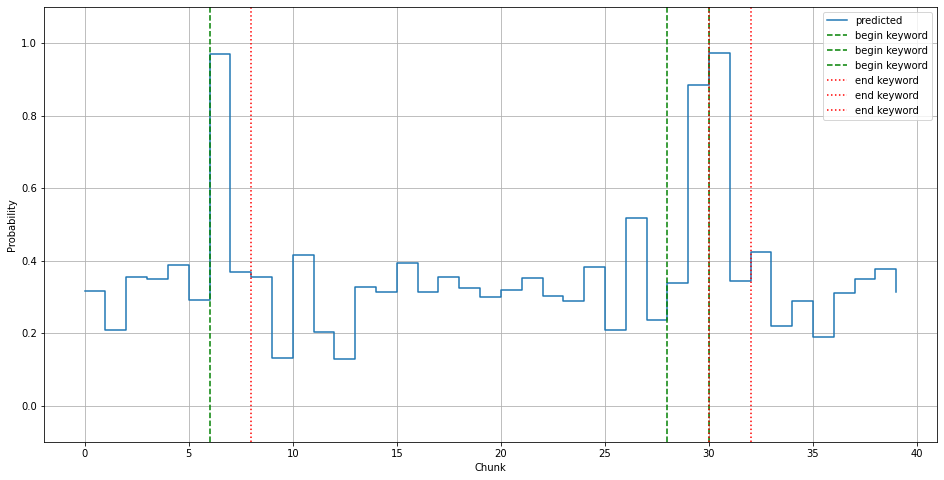

In [68]:
model = torch.load("kws.pth").eval()
plot_streaming(model)

## KWS class for distilled model

In [93]:
class CRNN_streaming(nn.Module):
    def __init__(self, base_model, config, max_window_length=40):
        super().__init__()
        self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)
        self.base_model = base_model

        self.min_window_length = base_model.conv[0].kernel_size[1]
        self.max_window_length = max_window_length
        self.frame_buffer = []

        self.last_hidden_state = None

    def forward_window(self, input):
        input = input.unsqueeze(dim=1)                      
        conv_output = self.base_model.conv(input).transpose(-1, -2)    
        gru_output, _ = self.base_model.gru(conv_output, self.last_hidden_state)              
        contex_vector = self.base_model.attention(gru_output)     
        logits = self.base_model.classifier(contex_vector) 
        probs = F.softmax(logits / 3.0, dim=-1)
        self.last_hidden_state = (gru_output[..., 0, :].detach())
        self.last_hidden_state = self.last_hidden_state[None, ...].repeat_interleave(self.base_model.gru.num_layers, dim=0)
        self.last_hidden_state[:-1, ...] = 0.0
        final_prob = probs[0][1]
        return final_prob
    
    def forward(self, chunk):
        spec = torch.log(self.melspec(chunk).clamp_(min=1e-9, max=1e9))
        steps = spec.shape[-1]
        max_prob = 0.0
        for step in range(steps):
          if len(self.frame_buffer) == self.max_window_length:
            self.frame_buffer = self.frame_buffer[1:]
          self.frame_buffer.append(spec[..., step])

          if len(self.frame_buffer) < self.min_window_length:
            continue

          input = torch.stack(self.frame_buffer, dim=-1)
          cur_prob = self.forward_window(input)
          if cur_prob > max_prob:
            max_prob = cur_prob

        return max_prob

In [94]:
best_model_dict = torch.load("model_best")

keys_to_delete = ["total_ops", "total_params", "conv.1.total_ops", "conv.1.total_params", "attention.total_ops", "attention.total_params", "attention.energy.1.total_ops", "attention.energy.1.total_params"]

for key in keys_to_delete:
  best_model_dict.pop(key)

config = TaskConfig(hidden_size=12, cnn_out_channels=3, kernel_size=(7, 20), stride=(6, 10), gru_num_layers=2)
model = CRNN(config).to(config.device)
model.load_state_dict(best_model_dict)

<All keys matched successfully>

In [ ]:
model_dynamic_quantized = torch.quantization.quantize_dynamic(
    model, qconfig_spec={torch.nn.GRU}, dtype=torch.qint8
)

In [173]:
streaming_model = CRNN_streaming(model_dynamic_quantized, config, max_window_length=100)

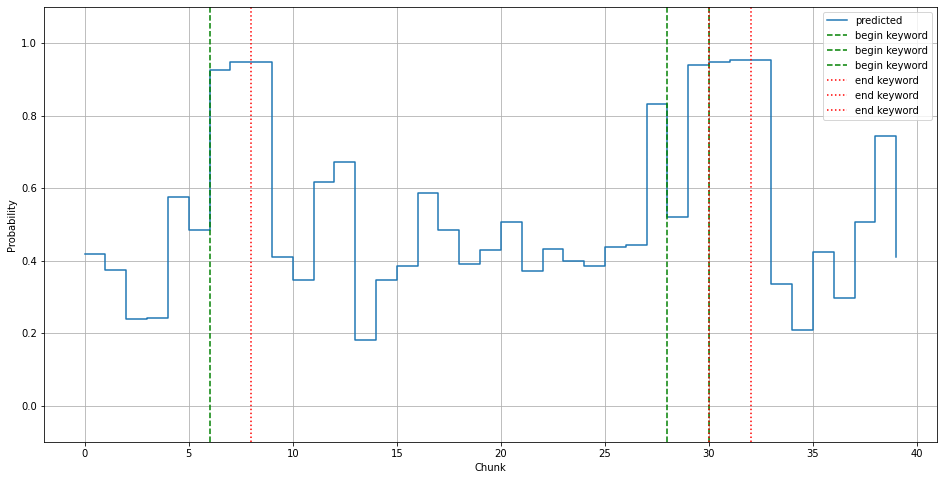

In [174]:
plot_streaming(streaming_model)

## jit save&load

In [175]:
model_scripted = torch.jit.script(streaming_model) 
model_scripted.save('model_scripted.pt')

/usr/local/lib/python3.7/dist-packages/torch/serialization.py:709: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  " silence this warning)", UserWarning)


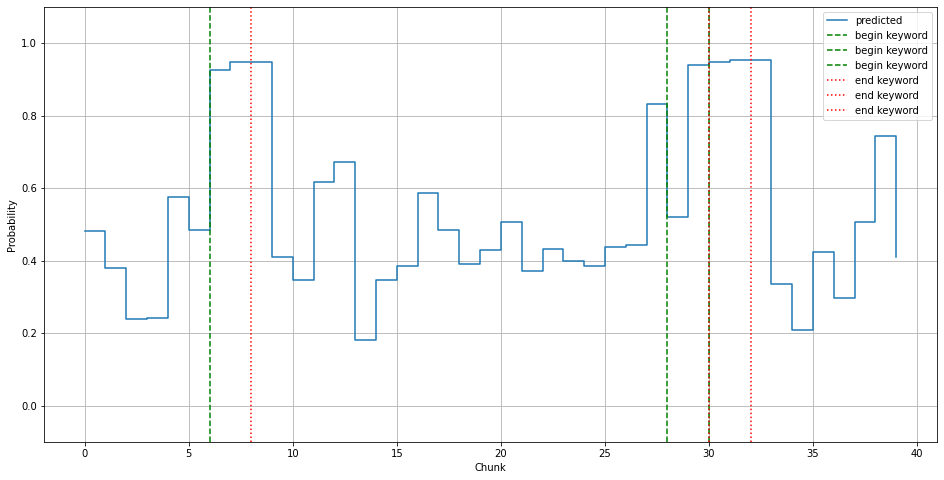

In [199]:
model = torch.load("model_scripted.pt").eval()
plot_streaming(model)